In [3]:
import rasterio
from shapely.geometry import mapping
import os
import rasterio.mask
from rasterio.enums import Resampling
from rasterio.warp import reproject, Resampling
from rasterio import features
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter
import elevation
import tempfile
import seaborn as sns
import osmnx as ox
import pyrosm
from src.utils import DATA_DIR, KILOMETERS_OFFSHORE

In [4]:
plt.style.use('dark_background')

## load data

In [5]:
brazil = gpd.read_file(f'{DATA_DIR}/brazil.geojson')                            # Brazil's shape
offshore = gpd.read_file(f'{DATA_DIR}/offshore.geojson')                        # Offshore shape (constructed by adding 100km buffer to Brazil's shape)
geometries = [mapping(polygon) for polygon in brazil.union(offshore).geometry]  # geometries of Union of Brazil and Offshore shapes

In [7]:
def load_from_global(fp):
    """
    fp: file path to metrological data
    geoms: list of shapely geometries to crop to brazil
    return: (raster, transform, meta)
    """
    with rasterio.open(f"{DATA_DIR}/{fp}") as src:
        out_image, out_transform = rasterio.mask.mask(src, geometries, crop=True)
        out_image = out_image[0]
        out_meta = src.meta
    return out_image, out_transform, out_meta

def load_from_brazil(fp):  # TODO: merge with topography loader
    """
    Load population data
    
    fp: file path to population data
    return: (raster, transform, meta)
    """
    with rasterio.open(f'{DATA_DIR}/{fp}') as src:
        return src.read(1), src.transform, src.meta

In [8]:
# metrological data
power_density, power_density_transform, power_density_meta = load_from_global(f'meterology/gwa3_250_powerdensity_100m.tif')
wind_speed, wind_speed_transform, wind_speed_meta = load_from_global(f'meterology/gwa3_250_windspeed_100m.tif')

In [9]:
# population data
population, population_transform, population_meta = load_from_brazil(f'demography/bra_pd_2020_1km.tif')

In [10]:
# topography data
topography, topography_transform, topography_meta = load_from_brazil('topography/brazil_dem.tif')
slope, slope_transform, slope_meta = load_from_brazil('topography/slope.tif'); slope = - slope  # slope is negatiuve for some reason
roughness, roughness_transform, roughness_meta = load_from_brazil('topography/roughness.tif')

## process data

In [11]:
def make_mask(raster, raster_transform, shape):  # shape is either brazil or offshore
    return features.rasterize(((geom, 1) for geom in shape.geometry), out_shape=raster.shape, transform=raster_transform, fill=0, default_value=1)

In [12]:
def scale_and_crop_raster(src_array, src_transform, src_crs, target_transform, target_shape, target_crs):
    # Create a destination array that will receive the reprojected values
    dest_array = np.empty(target_shape, dtype=src_array.dtype)

    # Perform the reprojection
    reproject(
        source=src_array,
        destination=dest_array,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=target_transform,
        dst_crs=target_crs,
        resampling=Resampling.nearest
    )

    return dest_array


In [19]:
# down scale to 1km (due to memory constraints). Analysis will improve if we upscale to topology, but this is a good start
power_density_scaled_to_population = scale_and_crop_raster(power_density, power_density_transform, power_density_meta['crs'], population_transform, population.shape, population_meta['crs'])
wind_speed_scaled_to_population = scale_and_crop_raster(wind_speed, wind_speed_transform, wind_speed_meta['crs'], population_transform, population.shape, population_meta['crs'])
roughness_scaled_to_population = scale_and_crop_raster(roughness, roughness_transform, roughness_meta['crs'], population_transform, population.shape, population_meta['crs'])
slope_scaled_to_population = scale_and_crop_raster(slope, slope_transform, slope_meta['crs'], population_transform, population.shape, population_meta['crs'])

In [20]:
brazil_mask = make_mask(population, population_transform, brazil)

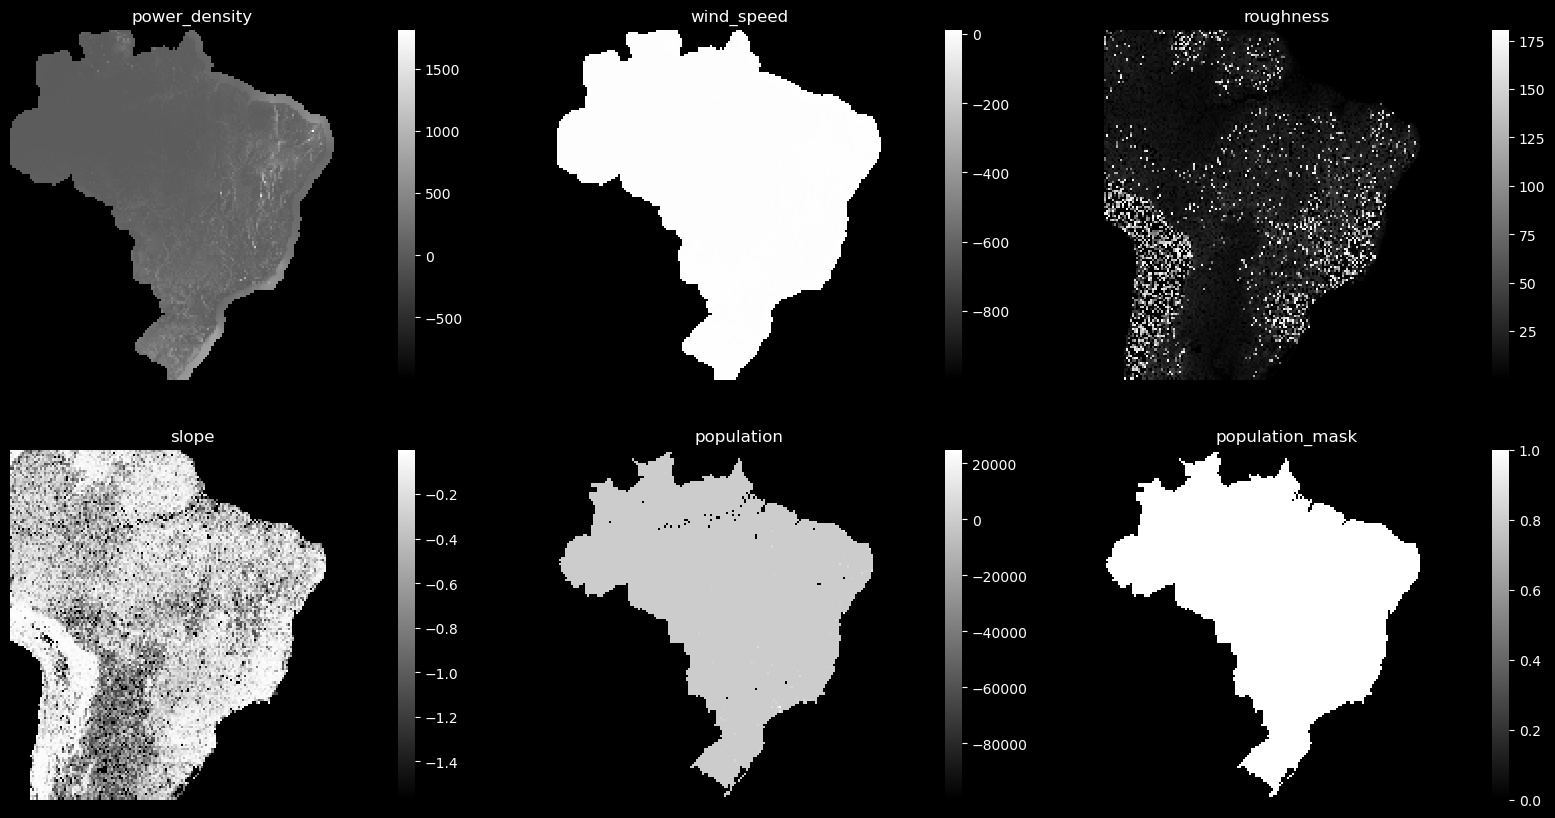

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for ax, raster, title in zip(axes.flatten(),
                            [power_density_scaled_to_population, wind_speed_scaled_to_population, roughness_scaled_to_population, slope_scaled_to_population, population, brazil_mask],
                            ['power_density', 'wind_speed', 'roughness', 'slope', 'population', 'population_mask']):
    # all outside of population mask is nan
    plot_data = (raster)[::30, ::30]  # * brazil_mask)[::30, ::30]
    ax.set_title(title)
    sns.heatmap(plot_data, ax=ax, cmap='gray')
    ax.axis('off')
plt.show()


### infrastructure | vector

In [55]:
# infrastructure data
landuse = gpd.read_file(f'{DATA_DIR}/infrastructure/landuse.csv', GEOM_POSSIBLE_NAMES="location", KEEP_GEOM_COLUMNS="NO")
power = gpd.read_file(f'{DATA_DIR}/infrastructure/power.csv', GEOM_POSSIBLE_NAMES="location", KEEP_GEOM_COLUMNS="NO")
powergeneration = gpd.read_file(f'{DATA_DIR}/infrastructure/powergeneration.csv', GEOM_POSSIBLE_NAMES="location", KEEP_GEOM_COLUMNS="NO")

## exploration

<Axes: >

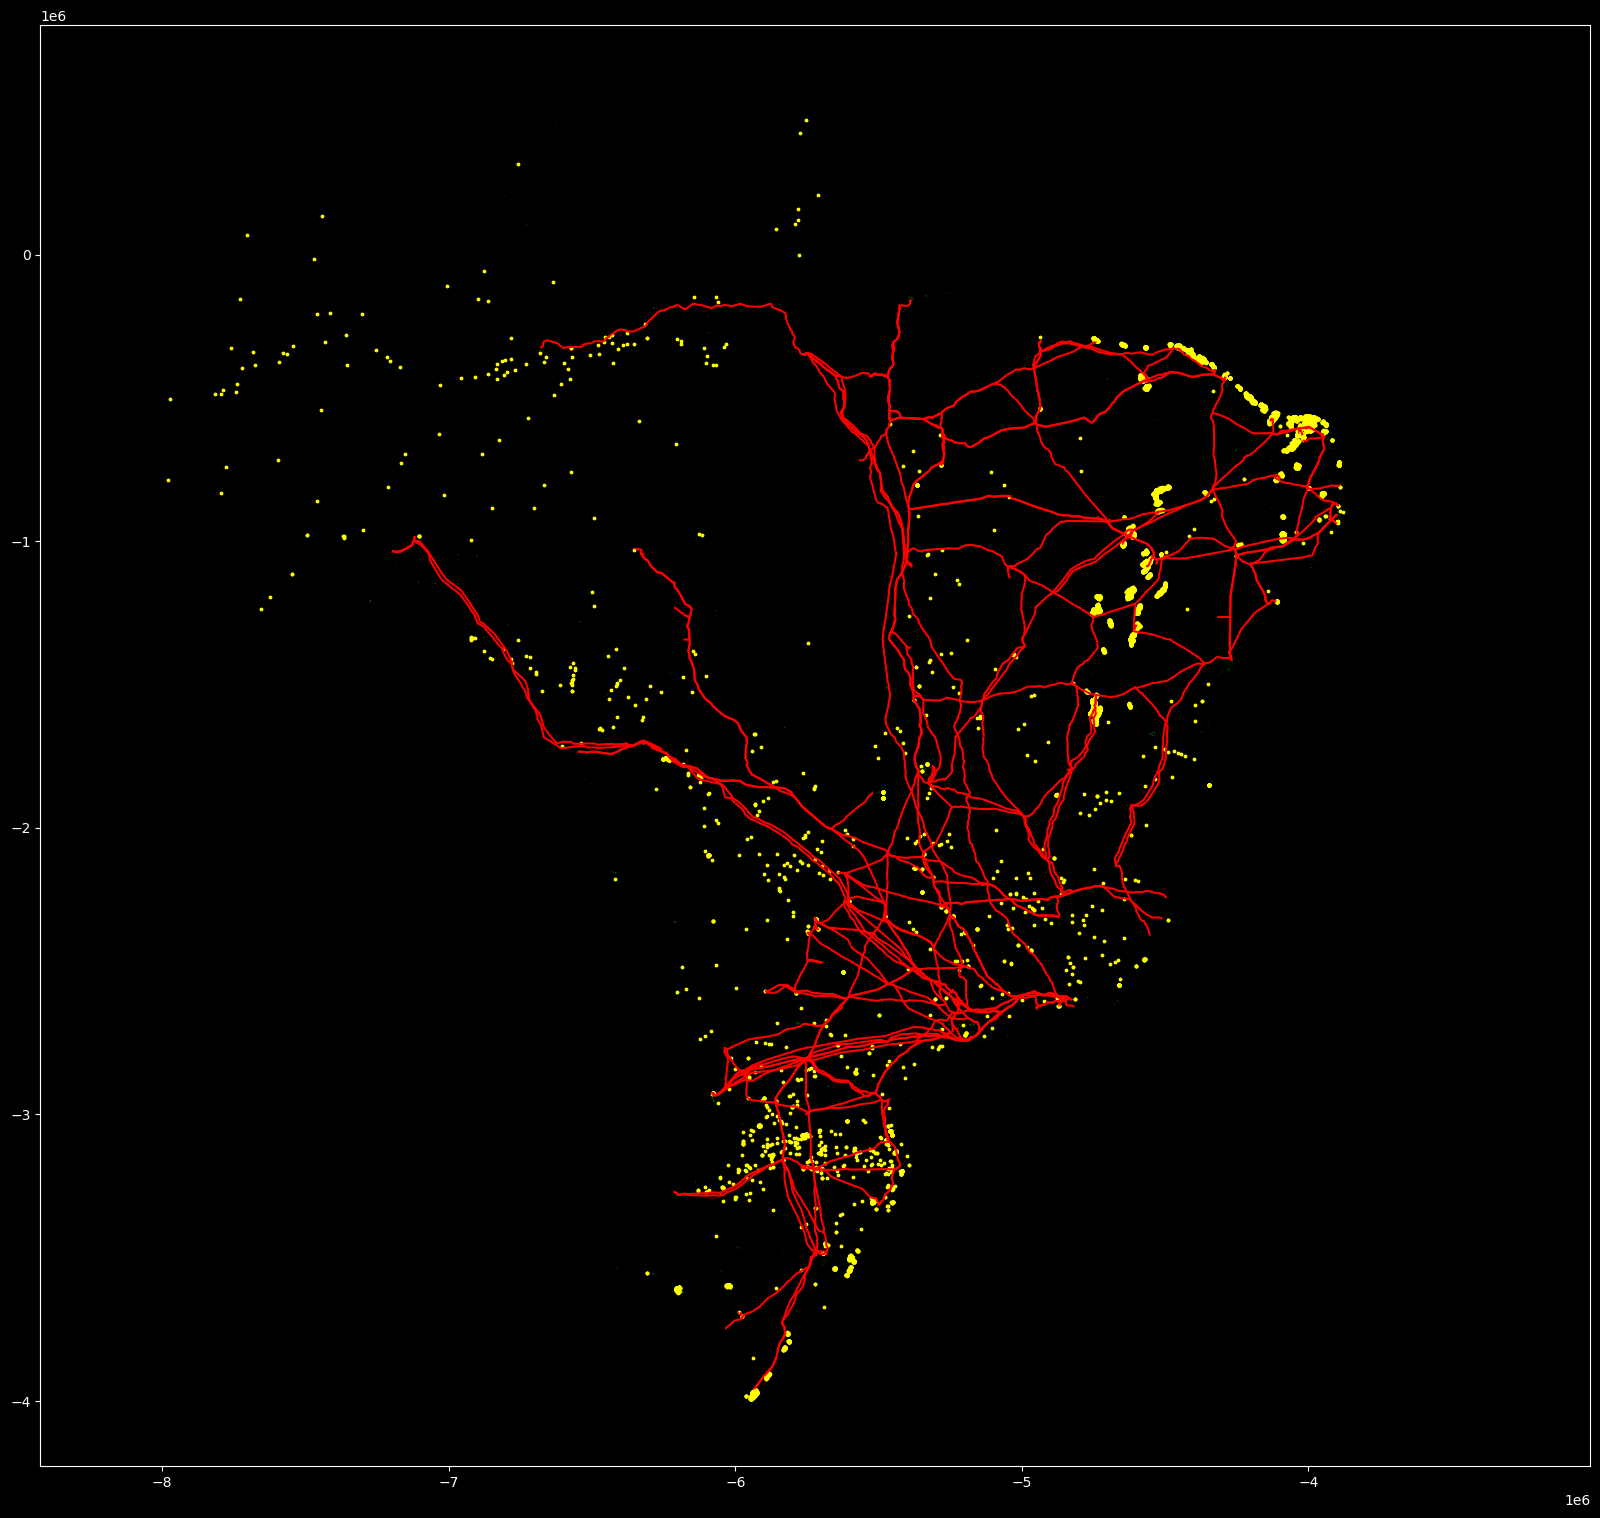

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
landuse.plot(ax=ax, color='green', markersize=3)
power.plot(ax=ax, color='red', markersize=3)
powergeneration.plot(ax=ax, color='yellow', markersize=3)

## constraints

In [ ]:
# this metereology mask is rater based and has the crs of the raster
metereology_mask = (wind_speed > 8) & (wind_speed < 12) & (power_density > 200)

In [ ]:

population_mask = population_density['Z'] < 1

In [21]:
wind_speed

array([[-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       ...,
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.]], dtype=float32)

## optimization